In [6]:
import cv2 as cv

def get_image_for_plotting(path):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return img

In [7]:
import math
import numpy as np

def apply_convolution(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    k = kernel.shape[0]
    r = k // 2

    # Pad the image with edges meaning we have a padding of r pixels on each side
    padded = np.pad(img, ((r, r), (r, r)))
    H, W = img.shape
    out = np.zeros((H, W), dtype=np.float32)
    ker = kernel.astype(np.float32)

    for y in range(H):
        for x in range(W):
            acc = 0.0
            for j in range(-r, r+1):
                for i in range(-r, r+1):
                    acc += float(padded[y + j + r, x + i + r]) * float(ker[j + r, i + r])
            out[y, x] = acc
    
    return out

sobel_x = np.array([[-1,-2,-1],
                    [ 0, 0, 0],
                    [ 1, 2, 1]], dtype=np.float32)
                             
sobel_y = np.array([[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]], dtype=np.float32)

def calculate_gradient(img: np.ndarray):
    gx = apply_convolution(img, sobel_x)
    gy = apply_convolution(img, sobel_y)

    H, W = gx.shape
    grad_magnitude = np.empty((H, W), dtype=np.float32)
    grad_angle     = np.empty((H, W), dtype=np.float32)  # radians in [-pi, pi]

    for y in range(H):
        for x in range(W):
            gxx = gx[y, x]
            gyy = gy[y, x]
            grad_magnitude[y, x] = math.sqrt(gxx*gxx + gyy*gyy)
            grad_angle[y, x]     = math.atan2(gyy, gxx)

    return grad_magnitude, grad_angle

In [8]:
def sobel_edge_detector(img, threshold):
    out_img_mag, _ = calculate_gradient(img)
    return (out_img_mag >= threshold).astype(np.uint8) * 255

def directional_edge_detector(img, direction_range):
    _, out_img_dir = calculate_gradient(img)
    
    deg = (np.degrees(out_img_dir) + 360.0) % 360.0
    low, high = direction_range
    mask = (deg >= low) & (deg <= high)

    return (mask.astype(np.uint8) * 255)

In [9]:
img = get_image_for_plotting("./images/sharp_edges.jpg")
edges_at_127 = sobel_edge_detector(img, 127)
edges_at_45_deg = directional_edge_detector(img, (40, 50))

edges_canny = cv.Canny(img, 100, 200, L2gradient=True, apertureSize=3)

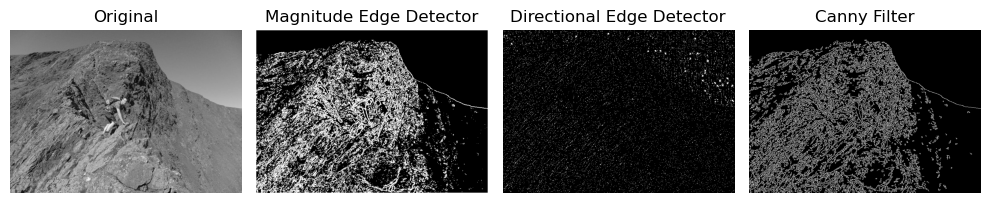

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(edges_at_127, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Magnitude Edge Detector")
ax[1].axis('off')

ax[2].imshow(edges_at_45_deg, cmap='gray', vmin=0, vmax=255)
ax[2].set_title("Directional Edge Detector")
ax[2].axis('off')

ax[3].imshow(edges_canny, cmap='gray', vmin=0, vmax=255)
ax[3].set_title("Canny Filter")
ax[3].axis('off')

plt.tight_layout()
plt.savefig("./images/output_detectors")